# Network Analysis - International Collaboration in the Art World
## Author: Jonathan Gat

## Libraries

In [1]:
# import libraries
import igraph as ig
import pandas as pd
import numpy as np
import itertools
import math
from sqlalchemy import create_engine

## Load data

In [2]:
# countries
countries = pd.read_json("CleanCountries.json", encoding='utf-8')
countries.head()

countryName countryCode capitalName  capitalLat  capitalLong  \
0     Afghanistan          AF       Kabul   34.516667    69.183333   
1   Aland Islands          AX   Mariehamn   60.116667    19.900000   
2         Albania          AL      Tirana   41.316667    19.816667   
3         Algeria          DZ     Algiers   36.750000     3.050000   
4  American Samoa          AS   Pago Pago  -14.266667  -170.700000   

  continentName      nationality  
0          Asia           Afghan  
1        Europe     Åland Island  
2        Europe         Albanian  
3        Africa         Algerian  
4     Australia  American Samoan

In [3]:
# artworks
artworks = pd.read_json("CleanedDataJG.json", encoding='utf-8')
artworks.head()

FID                                              Title  \
0    0  Ferdinandsbrücke Project, Vienna, Austria (Ele...   
1    1  City of Music, National Superior Conservatory ...   
2    2  Villa near Vienna Project, Outside Vienna, Aus...   
3    4  Villa, project, outside Vienna, Austria, Exter...   
4   30  Memorial to the Six Million Jewish Martyrs, pr...   

                       Artist NationalityCleaner nationalityCodes  \
0               [Otto Wagner]         [Austrian]             [14]   
1  [Christian de Portzamparc]           [French]             [74]   
2                [Emil Hoppe]         [Austrian]             [14]   
3                [Emil Hoppe]         [Austrian]             [14]   
4             [Louis I. Kahn]         [American]            [231]   

  Classification  tidyDate  Decade GenderClean  \
0   Architecture      1896    1890      [Male]   
1   Architecture      1987    1980      [Male]   
2   Architecture      1903    1900      [Male]   
3   Architecture      1903    1900      [Male]   
4   Architecture      1968    1960      [Male]   

                                              Medium  \
0      Ink and cut-and-pasted painted pages on paper   
1                  Paint and colored pencil on print   
2  Graphite, pen, color pencil, ink, and gouache ...   
3  Graphite, color pencil, ink, and gouache on tr...   
4             Charcoal and graphite on tracing paper   

                                        ThumbnailURL ConstituentID  ObjectID  \
0  http://www.moma.org/media/W1siZiIsIjU5NDA1Il0s...        [6210]         2   
1  http://www.moma.org/media/W1siZiIsIjk3Il0sWyJw...        [7470]         3   
2  http://www.moma.org/media/W1siZiIsIjk4Il0sWyJw...        [7605]         4   
3  http://www.moma.org/media/W1siZiIsIjEyNiJdLFsi...        [7605]         6   
4  http://www.moma.org/media/W1siZiIsIjE3MyJdLFsi...        [2964]        32   

  AccessionNumber                                      URL  
0        885.1996   http://www.moma.org/collection/works/2  
1          1.1995   http://www.moma.org/collection/works/3  
2          1.1997   http://www.moma.org/collection/works/4  
3          2.1997   http://www.moma.org/collection/works/6  
4          3.1997  http://www.moma.org/collection/works/32

## Create subset for artworks with more than one artist

In [4]:
# count number of artists per artwork
artworks['numOfArtists'] = artworks['Artist'].apply(lambda x: len(x))
artworks.numOfArtists.value_counts()

1     65692
2      1643
3       846
4        60
6        46
7        17
5        13
11        1
10        1
8         1
Name: numOfArtists, dtype: int64

In [5]:
# exclude artworks with only one artist
artworks = artworks[artworks['numOfArtists'] > 1]
print(artworks.numOfArtists.value_counts())
print(artworks.shape)

2     1643
3      846
4       60
6       46
7       17
5       13
11       1
10       1
8        1
Name: numOfArtists, dtype: int64
(2628, 16)


## Create Graph

In [164]:
# create a new graph
collab = ig.Graph()

# print
print(collab)

IGRAPH U--- 0 0 --


In [165]:
# add vertices to graph
collab.add_vertices(len(countries.countryName))

# add country name attributes to vertices
collab.vs['label'] = countries.countryName

# print
print(collab)

IGRAPH U--- 245 0 --
+ attr: label (v)


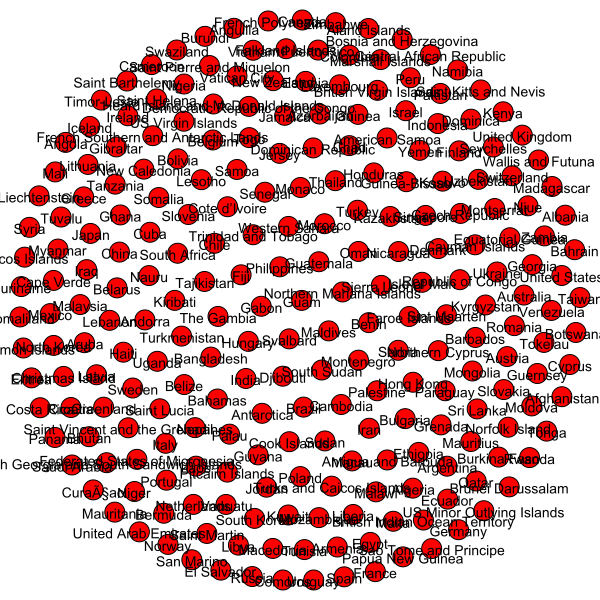

In [166]:
# plot the graph
ig.plot(collab)

## Transforming the Nationality List of each Artwork into Graph Edges

In [167]:
# declare a function that translates the nationality list
# of each artwork to edges in the newly created graph 
def listToGraph(dataframe,graph):
    '''This function translates a list of nodes (countries) to edges in graph, with an year attribute for each edge'''
    # the input list is the value in the column "nationalityCodes"
    inputList = dataframe.nationalityCodes
    # the year is the value in the "tidyDate" column
    year = dataframe.tidyDate
    # extract the number of elements in the list
    listLength = len(inputList)
    # using numpy, creating a cartesian product of all the elements in the input list
    matrix = np.array([el for el in itertools.product(inputList,inputList)])
    # a matrix of the same shape is created
    matrix_ind = np.arange(listLength**2).reshape(listLength,listLength)
    # locate the indices of the lower triangular matrix
    matrix_tri = matrix_ind[np.tril_indices(listLength,-1)]
    # extracting the relevant elements from the matrix object
    matrix_output = matrix[matrix_tri]
    # adding the relevant elements as edges
    graph.add_edges(matrix_output)
    # assigning an year attribute to each new edge
    for i in range(1,len(matrix_output)+1):
        # es stands for edge sequence, a member of the iGraph object, which can hold attributes on each edge in the graph
        graph.es[-i]['year'] = year
    

# apply the function on the nationality codes column
artworks.apply(listToGraph, graph = collab,axis =1)


9        None
17       None
36       None
39       None
40       None
         ... 
68120    None
68121    None
68122    None
68124    None
68125    None
Length: 2628, dtype: object

In [168]:
# plot
ig.plot(collab)

In [169]:
# remove vertices with no edges
collab.vs.select(_degree=0).delete()

In [170]:
# plot
ig.plot(collab)

In [171]:
# update the vertices dictionary
vertices = dict(zip(range(0,len(collab.vs['label'])),collab.vs['label']))
vertices

{0: 'Algeria',
 1: 'Argentina',
 2: 'Australia',
 3: 'Austria',
 4: 'Belgium',
 5: 'Bosnia and Herzegovina',
 6: 'Brazil',
 7: 'Canada',
 8: 'Chile',
 9: 'China',
 10: 'Colombia',
 11: 'Croatia',
 12: 'Cuba',
 13: 'Cyprus',
 14: 'Czech Republic',
 15: 'Denmark',
 16: 'Finland',
 17: 'France',
 18: 'Germany',
 19: 'Greece',
 20: 'Hungary',
 21: 'Iceland',
 22: 'India',
 23: 'Ireland',
 24: 'Israel',
 25: 'Italy',
 26: 'Japan',
 27: 'Kyrgyzstan',
 28: 'Latvia',
 29: 'Lebanon',
 30: 'Macedonia',
 31: 'Mexico',
 32: 'Netherlands',
 33: 'New Zealand',
 34: 'Norway',
 35: 'Peru',
 36: 'Poland',
 37: 'Portugal',
 38: 'Romania',
 39: 'Russia',
 40: 'Serbia',
 41: 'Slovenia',
 42: 'South Africa',
 43: 'Spain',
 44: 'Sweden',
 45: 'Switzerland',
 46: 'Ukraine',
 47: 'United Kingdom',
 48: 'United States',
 49: 'Uruguay',
 50: 'Venezuela'}

## Exploring some Structural Properties of the Network
Now we'll explore some struct.....
* Degree centrality
* Closeness
* Betweenes

In [215]:
# an empty dictionary for centrality measures
centrality_dic = {'country':collab.vs['label']}

### Degree Centrality

In [216]:
# calculating degree for all vertices
degree = {'degree':collab.degree()}
centrality_dic.update(degree)

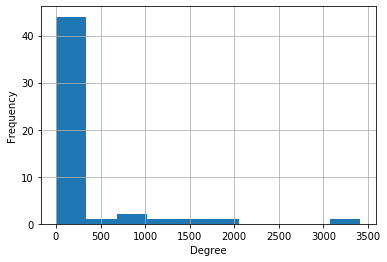

In [196]:
# creating a histogram
degreeHist = pd.Series(collab.degree()).hist()
degreeHist.set_xlabel("Degree")
degreeHist.set_ylabel("Frequency")
degreeHist.get_figure().savefig('degree_hist.png')

### Betweenness Centrality

In [217]:
# calculating betweenness centrality for all vertices
betweenness = {'betweenness':collab.betweenness()}
centrality_dic.update(betweenness)
centrality_dic

{'country': ['Algeria',
  'Argentina',
  'Australia',
  'Austria',
  'Belgium',
  'Bosnia and Herzegovina',
  'Brazil',
  'Canada',
  'Chile',
  'China',
  'Colombia',
  'Croatia',
  'Cuba',
  'Cyprus',
  'Czech Republic',
  'Denmark',
  'Finland',
  'France',
  'Germany',
  'Greece',
  'Hungary',
  'Iceland',
  'India',
  'Ireland',
  'Israel',
  'Italy',
  'Japan',
  'Kyrgyzstan',
  'Latvia',
  'Lebanon',
  'Macedonia',
  'Mexico',
  'Netherlands',
  'New Zealand',
  'Norway',
  'Peru',
  'Poland',
  'Portugal',
  'Romania',
  'Russia',
  'Serbia',
  'Slovenia',
  'South Africa',
  'Spain',
  'Sweden',
  'Switzerland',
  'Ukraine',
  'United Kingdom',
  'United States',
  'Uruguay',
  'Venezuela'],
 'degree': [9,
  1747,
  8,
  62,
  35,
  3,
  65,
  188,
  4,
  1,
  3,
  9,
  6,
  2,
  8,
  15,
  6,
  1523,
  690,
  1,
  1153,
  13,
  4,
  27,
  11,
  416,
  251,
  2,
  10,
  9,
  4,
  26,
  299,
  2,
  4,
  19,
  15,
  6,
  2,
  181,
  40,
  1,
  6,
  23,
  48,
  189,
  27,
  910,


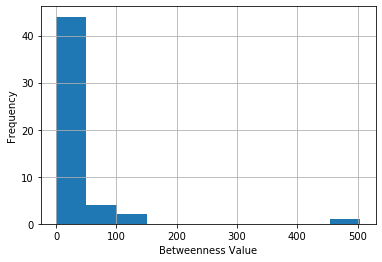

In [175]:
# creating a histogram
betweennessHist = pd.Series(collab.betweenness()).hist()
betweennessHist.set_xlabel("Betweenness Value")
betweennessHist.set_ylabel("Frequency")
betweennessHist.get_figure().savefig('betweenness_hist.png')

### Closeness Centrality

In [176]:
components = collab.components()
collab.vs['membership'] = components.membership

# what group nubmber should we look at?
pd.Series(components.membership).value_counts()

1    44
2     2
0     2
5     1
4     1
3     1
dtype: int64

Group 1 has the biggest number of vertices, let's exclude vertices that do not belong to that group

In [301]:
visual_style = {}
visual_style["vertex_size"] = 20
#visual_style["vertex_color"] = [color_dict[gender] for gender in g.vs["gender"]]
visual_style["vertex_label"] = collab.vs["label"]
#visual_style["edge_width"] = [1 + 2 * int(is_formal) for is_formal in g.es["is_formal"]]
visual_style["layout"] = 'kk'
#visual_style["bbox"] = (600, 600)
#visual_style["margin"] = 20

In [302]:
# creating a new graph for group 1
group1 = collab.copy()

# delete vertices outside group number 1
group1.vs.select(membership_ne=1).delete()

# plot
ig.plot(group1, 'plot.png',**visual_style)

In [248]:
# calculating closeness centrality for all vertices
closeness = {'country':group1.vs['label'],'closeness':group1.closeness()}
closeness_df = pd.DataFrame(closeness)
closeness_df = closeness_df.set_index('country')

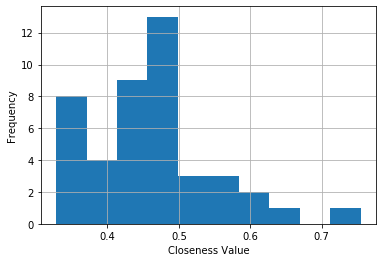

In [180]:
# creating a histogram
closenessHist = pd.Series(group1.closeness()).hist()
closenessHist.set_xlabel("Closeness Value")
closenessHist.set_ylabel("Frequency")
closenessHist.get_figure().savefig('closeness_hist.png')

### Concatenate Centrality Measures into One Data Frame

In [303]:
# create new data frame
centrality_df = pd.DataFrame(centrality_dic)
centrality_df = centrality_df.set_index('country')
# left join
centrality_df = pd.merge(centrality_df,closeness_df,on='country',how='left').sort_values(by=['degree'],ascending=False)

# exporting to csv file
centrality_df.to_csv('centrality.csv',encoding='utf-8')

## Counting Collaborations for each Pair of Countries

In [261]:
# create a new edge sequence that stores all the edges in the collaboration graph
edges = ig.EdgeSeq(collab)

# create new empty lists for tuples (pairs of vertices) and years
tupList = []
yearList = []

# iterate over the edge sequence and append the tuple and year attributes to the newly created lists
for i in edges:
    tupList.append(i.tuple)
    yearList.append(i.attributes()['year'])

In [262]:
# converting the tuple and year lists to a data frame
dictionary = {'edge':tupList,'year':yearList}
edgesDf = pd.DataFrame(dictionary, columns=['edge','year'])
edgesDf

edge  year
0     (32, 32)  1987
1     (25, 25)  1974
2     (25, 25)  1974
3     (25, 25)  1974
4     (44, 44)  1937
...        ...   ...
5813  (18, 48)  1929
5814  (18, 48)  1929
5815  (18, 48)  1929
5816  (39, 39)  1913
5817  (39, 39)  1913

[5818 rows x 2 columns]

In [263]:
# creating a pivot table to count the number of collaborations for each unique combination
edgesDf_pivot = edgesDf.pivot_table(index='edge',columns='year',aggfunc=lambda x: x['edge'].value_counts().to_list()[0])
edgesDf_pivot['Total'] = edgesDf_pivot.sum(axis = 1)

# converting na to 0 collaborations
edgesDf_pivot = edgesDf_pivot.fillna(0)

## Adding Country Names and Lat/Long to each Unique Pair of Countries

In [264]:
# creating a new data frame, each row represents a unique pair of countries
d = {'edge':edgesDf_pivot.index.values}
edgesDf_countries = pd.DataFrame(d)

# adding new columns with country names using the vertices dictionary
edgesDf_countries['country1'] = edgesDf_countries['edge'].apply(lambda x: x[0]).map(vertices)
edgesDf_countries['country2'] = edgesDf_countries['edge'].apply(lambda x: x[1]).map(vertices)

In [265]:
# creating a new dictionary for lat/long coordinates of each capitol city in each country
latLongDic = {}
for i in range(len(countries)):
    latLongDic[countries.iloc[i,0]] = [countries.iloc[i,3],countries.iloc[i,4]]

In [266]:
# adding new columns with capitol cities coordinates using the lat/long dictionary
edgesDf_countries['country1_lat'] = edgesDf_countries['country1'].apply(lambda x: latLongDic[x][0])
edgesDf_countries['country1_lon'] = edgesDf_countries['country1'].apply(lambda x: latLongDic[x][1])

edgesDf_countries['country2_lat'] = edgesDf_countries['country2'].apply(lambda x: latLongDic[x][0])
edgesDf_countries['country2_lon'] = edgesDf_countries['country2'].apply(lambda x: latLongDic[x][1])

## Adding New Columns for Midpoint Lat/Long Values
In our web application, we are using the [leaflet curve extention](https://github.com/elfalem/Leaflet.curve) in order to create visually appealing curves, each curve represent an edge in our network. The following chunk of code creates new columns for lat/long coordinates for a single midpoint for each pair of countries, and is based on an article by Ryan Catalani [which was published on Medium in 2017](https://medium.com/@ryancatalani/creating-consistently-curved-lines-on-leaflet-b59bc03fa9dc), using a polar coordinate system.

In [267]:
# iterating over the edgesDf_countries data frame 
for i in range(len(edgesDf_countries)):
    # calculating x and y offset
    offset_x = edgesDf_countries.iloc[i,6] - edgesDf_countries.iloc[i,4]
    offset_y = edgesDf_countries.iloc[i,5] - edgesDf_countries.iloc[i,3]
    # converting offsets a polar coordinate system
    r = math.sqrt(math.pow(offset_x,2) + math.pow(offset_y,2))
    theta = math.atan2(offset_y,offset_x)
    thetaOffset = (math.pi/10)
    r2 = (r/2)/(math.cos(thetaOffset))
    theta2 = theta + thetaOffset
    # assigning values to x and y midpoint variables
    midpoint_x = (r2 * math.cos(theta2)) + edgesDf_countries.iloc[i,4]
    midpoint_y = (r2 * math.sin(theta2)) + edgesDf_countries.iloc[i,3]
    # adding new colums for x and y midpoint coordinates
    edgesDf_countries.loc[i,'midpoint_lat'] = midpoint_y
    edgesDf_countries.loc[i,'midpoint_lon'] = midpoint_x

In [268]:
# reset index
edgesDf_pivot = edgesDf_pivot.reset_index(drop=True)

# exclude undesired columns from edgesDf_countries
edgesDf_countries = edgesDf_countries.iloc[:,1:len(edgesDf_countries.index.values)]

## Merging the Two Data Frames before Export

In [269]:
# this tabular join is based on the mutual index of the data frames
export = pd.concat([edgesDf_countries, edgesDf_pivot], axis=1, join='inner')

In [271]:
# exclude collaborations within the same country
export = export.loc[export['country1'] != export['country2']]

In [272]:
# reset index
export = export.reset_index(drop=True)
export.index.name = 'collab_id'

## Eliminating Columns with no Collaboration Counts
In the previous cell, we excluded collaborations within the same country. We don't want to get stuck with year columns with no collaboration counts, so let's find these irrelevant columns and exclude them from our data frame.

In [273]:
# summing the columns in the export data frame
exportSum = export.sum()

# creating an empty list for columns to keep
columnsToRemove = []

# iterating over the index values and appending
# columns with sum of zero to the columnsToKeep list
for i in exportSum.index.values:
    if exportSum[i] == 0:
        columnsToRemove.append(i)

# now we can use list comprehension to locate what are the *existing* columns that we do want to keep
columnsToKeep = [x for x in export.columns if x not in columnsToRemove]

# excluding columns with no collaboration counts
export = export.loc[:,columnsToKeep]

## Scale the Totals
Total values were taken to visualise the with of each arch in the online application. The width property of each arch varies from 1 (least collaborations) to 15 (most collaborations). In order to rescale the total, we use the following formula:

$
x_{normalised} = (b-a)\frac{x-min(x)}{max(x)-min(x)}+a
$

when $[a,b]$ is the range of width values.

In [274]:
# define a new function
def normTotal(val, widthRange):
    '''This function nurmalises the total number of collaboration per row for the range [a,b]'''
    a = widthRange[0]
    b = widthRange[1]
    min_x = min(export['Total'])
    max_x = max(export['Total'])
    return (b-a)*((val-min_x)/(max_x-min_x))+a
    
# apply the function
export['scaledTotal'] = export['Total'].apply(normTotal, widthRange = [1,15])

In [275]:
# let's take a look
export

country1        country2  country1_lat  country1_lon  \
collab_id                                                               
0                 Algeria         Lebanon     36.750000      3.050000   
1               Argentina          Brazil    -34.583333    -58.666667   
2               Argentina         Germany    -34.583333    -58.666667   
3               Argentina           Italy    -34.583333    -58.666667   
4               Argentina          Mexico    -34.583333    -58.666667   
...                   ...             ...           ...           ...   
113                Sweden   United States     59.333333     18.050000   
114           Switzerland  United Kingdom     46.916667      7.466667   
115           Switzerland   United States     46.916667      7.466667   
116        United Kingdom   United States     51.500000     -0.083333   
117         United States         Uruguay     38.883333    -77.000000   

           country2_lat  country2_lon  midpoint_lat  midpoint_lon  1860  1900  \
collab_id                                                                       
0             33.866667     35.500000     40.580155     19.743426   0.0   0.0   
1            -15.783333    -47.916667    -23.436890    -56.345912   0.0   0.0   
2             52.516667     13.400000     20.674606    -36.783586   0.0   0.0   
3             41.900000     12.483333     15.217352    -35.517138   0.0   0.0   
4             19.433333    -99.133333    -14.149208    -87.675539   0.0   0.0   
...                 ...           ...           ...           ...   ...   ...   
113           38.883333    -77.000000     33.666525    -26.152696   0.0   0.0   
114           51.500000     -0.083333     47.981761      2.947059   0.0   0.0   
115           38.883333    -77.000000     29.177558    -33.461572   0.0   0.0   
116           38.883333    -77.000000     32.695796    -36.491965   1.0   0.0   
117          -34.850000    -56.166667      5.401247    -54.604627   0.0   0.0   

           ...  2011  2012  2013  2014  2015  2016  2017  2018  Total  \
collab_id  ...                                                          
0          ...   0.0   0.0   0.0   0.0   0.0   9.0   0.0   0.0    9.0   
1          ...   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0    1.0   
2          ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    2.0   
3          ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    2.0   
4          ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    2.0   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...    ...   
113        ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    6.0   
114        ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    4.0   
115        ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   11.0   
116        ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   38.0   
117        ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    1.0   

           scaledTotal  
collab_id               
0             1.190476  
1             1.000000  
2             1.023810  
3             1.023810  
4             1.023810  
...                ...  
113           1.119048  
114           1.071429  
115           1.238095  
116           1.880952  
117           1.000000  

[118 rows x 97 columns]

# Upload to Server

In [276]:
# create engine
engine = create_engine('') 
# make the connection to the database
conn = engine.raw_connection()

In [277]:
# export the dataframe
export.to_sql('collab', con=engine)

# Export to JSON File

In [ ]:
# export the data frame
export.to_json('collab.json',orient='records')